In [1]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as Image
import random
import collections
from skimage import measure, color
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

In [2]:
k_num = [2, 5, 6, 3, 3, 
         4, 2, 3, 3, 5, 
         5, 6, 5, 4, 5,
         3, 5, 5, 6, 6,
         7, 6, 5, 7, 7, 
         4, 5, 7, 7, 6, 
         7, 6, 7, 5, 6,
         7, 6, 7, 9, 6,
         2, 3, 7, 7, 6, 
         5, 6]

In [3]:
def IOU(in1, in2):
    
    img1 = in1.astype('int')
    img2 = in2.astype('int')
    I = int(np.sum(img1 & img2))
    U = int(np.sum(img1 | img2))
    out = round((I / U), 4)
    
    return out

In [4]:
def LoG(img, ksize, scale):
    
    temp = np.copy(img)
    gaussian = cv2.GaussianBlur(temp, (ksize, ksize), 0)
    out = cv2.Laplacian(gaussian, -1, ksize = ksize, scale = scale)
    
    return out

In [5]:
def integralHist(img, n = 11, w = 0):
    
    temp0 = np.copy(img).astype(int)
    temp0.resize([1, img.shape[0]*img.shape[1]])
    temp = 11 * (temp0[0] - temp0[0].min())
    width = float((temp.max() - temp.min()) / n)
    temp.resize([img.shape[0], img.shape[1]])
    
    def oneBin(src, z1, z2, w = 0):
        
        padding = w - 1
        
        RS = np.zeros(src.shape)
        HI = np.zeros(src.shape)
        for i in range(src.shape[0]):
            for j in range(src.shape[1]):
                if i == 0:
                    RS[i][j] = 1 if ((src[i][j] >= z1)&(src[i][j] < z2)) else 0
                else:
                    RS[i][j] = RS[i-1][j] + 1 if ((src[i][j] >= z1)&(src[i][j] < z2)) else RS[i-1][j]
                if j == 0:
                    HI[i][j] = 1 if ((src[i][j] >= z1)&(src[i][j] < z2)) else 0
                else:
                    HI[i][j] = HI[i][j-1] + RS[i][j]
        
        if w != 0:
            padding0 = np.zeros([HI.shape[0], padding])
            padding1 = np.zeros([padding, HI.shape[1] + padding])
            tempA = np.r_[np.c_[HI, padding0], padding1]
            tempB = np.r_[np.c_[padding0, HI], padding1]
            tempC = np.r_[padding1, np.c_[HI, padding0]]
            tempD = np.r_[padding1, np.c_[padding0, HI]]
            out = tempA + tempD - tempB - tempC
        else:
            out = HI
        
        out = out.astype(int)
#         dst = out[int(w/2):out.shape[0]-int(w/2), int(w/2):out.shape[1]-int(w/2)]
        dst = out[:out.shape[0]-w+1, :out.shape[1]-w+1]
        dst = dst.reshape([1, dst.shape[0]*dst.shape[1]])
        
        return dst[0].astype(int)
    
    bins = list()
    for k in range(0, n):
#         print('Initializing Bin', k, '...')
        HI = oneBin(temp, k*width, (k+1)*width, w)
#         print('Bin', k, 'finished')
        bins.append(HI)
    
    return bins

In [6]:
def cleaning(img):
    
    N = img.shape[0] * img.shape[1]
    clusters = int(img.max())
    temp = img.astype('int')
    out = np.copy(img)
    for i in range(0, clusters):
        seg = np.argwhere(temp == i)
        if (seg.shape[0] < 0.01 * N):
            if seg[:,0].min() != seg[:,0].max():
                p00 = seg[:,0].min()
                p01 = seg[:,0].max()
            else:
                p00 = seg[0,0]
                p01 = p00 + 1
            if seg[:,1].min() != seg[:,1].max():
                p10 = seg[:,1].min()
                p11 = seg[:,1].max()
            else:
                p10 = seg[0,1]
                p11 = p10 + 1
            window = temp[p00:p01, p10:p11]
            (value, counter) = np.unique(window, return_counts=True)
            count = counter
            count[np.argmax(counter)] = 0
            for p in range(seg.shape[0]):
                out[seg[p][0], seg[p][1]] = value[np.argmax(count)]
    
    return out

In [7]:
def segImg(img, clusters, kernel_size = 5):
    
    # integration scale
    temp = int(0.04 * np.max(img.shape))
    w_s = temp if temp%2 != 0 else temp - 1 
    window_size = w_s if w_s > 14 else 21
    
    # kernel size
    k_size = kernel_size
    
    # the L*a*b* color space is more perceptually uniform when intensity filter applied
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    median_L = cv2.medianBlur(l, k_size)
    median_a = cv2.medianBlur(a, k_size)
    median_b = cv2.medianBlur(b, k_size)
    
    # gray scale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    log_05 = LoG(img_gray, k_size, 0.5)
    log_08 = LoG(img_gray, k_size, 0.8)
    log_12 = LoG(img_gray, k_size, 1.2)
    
    # feature extraction and splicing
    bins_L = integralHist(median_L, w = window_size)
    print('L channel finished')
    bins_A = integralHist(median_a, w = window_size)
    print('a channel finished')
    bins_B = integralHist(median_b, w = window_size)
    print('b channel finished')
    bins05 = integralHist(log_05, w = window_size)
    print('LoG-0.5 finished')
    bins08 = integralHist(log_08, w = window_size)
    print('LoG-0.8 finished')
    bins12 = integralHist(log_12, w = window_size)
    print('LoG-1.2 finished')
    
    Y = np.concatenate((np.array(bins_L), np.array(bins_A), 
                        np.array(bins_B), np.array(bins05), 
                        np.array(bins08), np.array(bins12)),axis=0)
    
    # k-means clustering
    estimator = KMeans(n_clusters = clusters)
    estimator.fit(Y.T)
    label_pred = estimator.labels_
    centroids = estimator.cluster_centers_
    
    # segmentation
    w = window_size
    out = label_pred.reshape([img.shape[0], img.shape[1]])
    temp = out[int(w/2):, int(w/2):out.shape[1]]
    temp = np.ones(temp.shape) + temp.astype('int')
    labels = measure.label(temp, connectivity=2)
    x = labels.max() + 1
    padding = int(w/2)
    padding0 = x * np.ones([labels.shape[0], padding])
    padding1 = x * np.ones([padding, labels.shape[1] + padding])
    del(out)
    out = np.r_[np.c_[labels, padding0], padding1]
    out = out - np.ones(out.shape)
    del(temp)
    temp = out
    del(out)
    out = cleaning(temp)
    
    return out

In [8]:
def oneAxis(img, ellipse, angle):
    
    points = np.nonzero(img)
    N = len(points[0])
    x0 = ellipse[0][0]
    y0 = ellipse[0][1]
    
    theta = (angle)*np.pi/180
    temp = 2*np.tan(theta)/(np.power(np.tan(theta), 2) + 1)
    
    if round(np.tan(theta), 4) == 0.0:
        t = 0
        out = list()
        for i in range(N):
            x = points[1][i]
            y = points[0][i]
            X = x
            Y = int(round((2 * y0 - y), 0))
            if (Y < img.shape[0])&(X < img.shape[1]):
                if img[Y][X] != 0:
                    t = t + 1
                    out.append([y, x])
                    
    elif round(1/np.tan(theta), 4) == 0.0:
        t = 0
        out = list()
        for i in range(N):
            x = points[1][i]
            y = points[0][i]
            X = int(round((2 * x0 - x), 0))
            Y = y
            if (Y < img.shape[0])&(X < img.shape[1]):
                if img[Y][X] != 0:
                    t = t + 1
                    out.append([y, x])
                    
    else:
        t = 0
        out = list()
        for i in range(N):
            x = points[1][i]
            y = points[0][i]
            X = int(round((temp*(np.tan(theta)*x0 - y0 + x/np.tan(theta) + y) - x), 0))
            Y = int(round((temp*(y0/np.tan(theta) - x0 + x + np.tan(theta)*y) - y), 0))
            if (Y < img.shape[0])&(X < img.shape[1]):
                if img[Y][X] != 0:
                    t = t + 1
                    out.append([y, x])
    
    return (round(t/N, 4))

In [9]:
def center(img, ellipse):
    
    points = np.nonzero(img)
    N = len(points[0])
    x0 = ellipse[0][0]
    y0 = ellipse[0][1]
    
    t = 0
    out = list()
    for i in range(N):
        x = points[1][i]
        y = points[0][i]
        X = int(round(2*x0 - x, 0))
        Y = int(round(2*y0 - y, 0))
        if (Y < img.shape[0])&(X < img.shape[1]):
            if img[Y][X] != 0:
                t = t + 1
                out.append([y, x])
    
    return (round(t/N, 4))

In [10]:
def fitting(img):
    
    N = img.shape[0] * img.shape[1]
    clusters = int(img.max())
    temp = img.astype('int')
    E = list()
    for i in range(0, clusters):
        seg = np.zeros(img.shape)
        pos = np.argwhere(temp == i)
        for p in range(pos.shape[0]):
            seg[pos[p][0], pos[p][1]] = 255
        seg = seg.astype('uint8')
        cont, hier = cv2.findContours(seg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        if len(cont) == 0:
            continue
        maxlen = max(len(cont[j]) for j in range(len(cont)))
        for i in range(len(cont)):
            if len(cont[i]) == maxlen:
                cnt = cont[i]
        if len(cnt) < 5:
            continue
        img_edge = np.zeros(seg.shape, seg.dtype)
        img_fit = np.zeros(seg.shape, seg.dtype)
        ellipse = cv2.fitEllipse(cnt)
        cv2.drawContours(img_edge, [cnt], 0, (1, 1, 1), -1)
        cv2.ellipse(img_fit, ellipse, (1, 1, 1), -1)
        
        # area limitation
        if (len(img_fit.nonzero()[0]) < 0.01 * N):
            continue
        if (len(img_fit.nonzero()[0]) > N):
            continue
        if (len(img_fit.nonzero()[0]) < (3/4*((ellipse[1][0]/2)*(ellipse[1][1]/2)*np.pi))):
            continue
        
        # the similarity between the area selected to an ellipse
        if (IOU(img_edge, img_fit) < 0.8):
            continue
        if (ellipse[1][0] > img.shape[0])|(ellipse[1][1] > img.shape[1]):
            continue
        
        # the aspect ratio
        if(ellipse[1][0] > ellipse[1][1]):
            if ellipse[1][1]/ellipse[1][0] > 0.9:
                ratio = 1
            else: 
                ratio = 1 if (ellipse[2] < 35)|(ellipse[2] > 145) else 0
        else:
            if ellipse[1][0]/ellipse[1][1] > 0.9:
                ratio = 1
            else:
                ratio = 1 if (ellipse[2] > 55)&(ellipse[2] < 125) else 0
        if ratio == 0:
            continue
        
        E.append(ellipse)
    
    if len(E) > 1:
        EG = list()
        for i in range(len(E)):
            ground = np.zeros(img.shape)
            cv2.ellipse(ground, E[i], (1,1,1), -1)
            EG.append(ground)
        
        temp_del = list()
        for x in range(len(EG)-1):
            for y in range(x+1, len(EG)):
                if IOU(EG[x], EG[y]) > 0.95:
                    temp_del.append(y)
                    
        delete = list()
        [delete.append(i) for i in temp_del if not i in delete]
        out = list()
        for i in range(len(E)):
            if i in delete:
                continue
            out.append(E[i])
    else:
        out = E
        
    return out

In [13]:
Segment = list()
Fitting = list()
Merge = list()
GT = list()

for i in range(47):
    I = str(i)
    print('Pic', i, 'is processing:\n')
    img = cv2.imread(str(i) + ".jpg")
    gt = cv2.imread("G" + str(i) + ".jpg", 0)
    GT.append(gt)
    seg = segImg(img, k_num[i])
    Segment.append(seg)
    E = fitting(seg)
    print('In picture', i, len(E), 'ellipses detected.')
    img_fit = np.zeros(seg.shape)
    img_merge = np.copy(img)
    for k in range(len(E)):
        cv2.ellipse(img_fit, E[k], (255, 255, 255), -1)
        cv2.ellipse(img_merge, E[k], (0, 255, 0), -1)
    Fitting.append(img_fit)
    Merge.append(img_merge)
    out_show = np.expand_dims(img_fit, axis=2)
    out_show = np.concatenate((out_show, out_show, out_show), axis=-1)
    out_show = cv2.normalize(out_show, out_show, 0, 255, cv2.NORM_MINMAX)
    out_img = np.concatenate((img, out_show), axis = 1)
    out_img = out_img.astype('uint8')
    file_name = './out/Seg/LoG/segmentation/S' + I + '.png'
    Image.imsave(file_name, seg)
    file_name = './out/Seg/LoG/compare/C' + I + '.png'
    Image.imsave(file_name, out_img)
    file_name = './out/Seg/LoG/merge/M' + I + '.png'
    Image.imsave(file_name, img_merge)
    print('\nPic', i, 'is done!\n')

Pic 0 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 0 1 ellipses detected.

Pic 0 is done!

Pic 1 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 1 1 ellipses detected.

Pic 1 is done!

Pic 2 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 2 1 ellipses detected.

Pic 2 is done!

Pic 3 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 3 1 ellipses detected.

Pic 3 is done!

Pic 4 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 4 1 ellipses detected.

Pic 4 is done!

Pic 5 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished

In picture 44 1 ellipses detected.

Pic 44 is done!

Pic 45 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 45 2 ellipses detected.

Pic 45 is done!

Pic 46 is processing:

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished
In picture 46 1 ellipses detected.

Pic 46 is done!



In [72]:
# evaluation according to images

exact = list()
almost = list()
none = list()
less = list()
more = list()
wrong = list()
for i in range(47):
    gt = GT[i]
    res = Fitting[i]
    value = IOU(gt, res)
    if value == 0.0:
        if (len(np.nonzero(res)[0]) == 0):
            none.append(i)
            print(i, 'none:', value)
        else:
            wrong.append(i)
            print(i, 'wrong:', value)
    elif value >= 0.85:
        exact.append(i)
        print(i, 'exact:', value)
    elif (value < 0.85)&(value > 0.7):
        almost.append(i)
        print(i, 'almost:', value)
    else:
        if (len(np.nonzero(res)[0]) > len(np.nonzero(gt)[0])):
            more.append(i)
            print(i, 'more:', value)
        else:
            less.append(i)
            print(i, 'less:', value)
print('\nNone', len(none), '\nLess:', len(less), '\nWrong', len(wrong), '\nMore', len(more), '\nAlmost', len(almost), '\nExact', len(exact))

0 exact: 0.96
1 exact: 0.9058
2 almost: 0.7397
3 exact: 0.863
4 exact: 0.8887
5 wrong: 0.0
6 exact: 0.9739
7 almost: 0.713
8 wrong: 0.0
9 more: 0.4502
10 less: 0.2854
11 less: 0.2042
12 exact: 0.8767
13 less: 0.0315
14 exact: 0.8843
15 almost: 0.7696
16 none: 0.0
17 none: 0.0
18 more: 0.1373
19 almost: 0.7775
20 more: 0.5775
21 none: 0.0
22 more: 0.0698
23 exact: 0.917
24 exact: 0.8972
25 none: 0.0
26 none: 0.0
27 exact: 0.9106
28 more: 0.1282
29 wrong: 0.0
30 wrong: 0.0
31 none: 0.0
32 none: 0.0
33 none: 0.0
34 wrong: 0.0
35 wrong: 0.0
36 none: 0.0
37 none: 0.0
38 none: 0.0
39 none: 0.0
40 exact: 0.9352
41 exact: 0.9685
42 more: 0.4025
43 wrong: 0.0
44 exact: 0.9308
45 more: 0.5692
46 more: 0.2973

None 12 
Less: 3 
Wrong 7 
More 8 
Almost 4 
Exact 13


In [73]:
Seg_array = np.array(Segment)
np.save('./out/Seg/LoG/segArray.npy', Seg_array)

In [74]:
def showImg(grp):
    
    r = len(grp)/4 if len(grp)%4 == 0 else int(len(grp)/4)+1
    fig = plt.figure(figsize=(20,8*r))
    for i in range(len(grp)):
        ax = plt.subplot(r, 4, i+1)
        plt.title(str(grp[i]))
        plt.imshow(Merge[grp[i]])

In [109]:
def ellipseSet(img):
    
    temp = np.copy(img)
    ret,temp = cv2.threshold(temp,127,255,cv2.THRESH_BINARY)
    labels = measure.label(temp, connectivity=2)
    del(temp)
    num = labels.max()
    
    ELL = list()
    for i in range(num):
        temp = labels - (i+1)*np.ones(labels.shape)
        points = np.nonzero(temp)
        tempImg = np.zeros(labels.shape)
        for j in range(len(points[0])):
            tempImg[points[0][j]][points[1][j]] = 1
        tempImg = tempImg.astype('uint8')
        cont, hier = cv2.findContours(tempImg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        maxlen = max(len(cont[k]) for k in range(len(cont)))
        for p in range(len(cont)):
            if len(cont[p]) == maxlen:
                cnt = cont[p]
        ellipse = cv2.fitEllipse(cnt)
        ELL.append(ellipse)
    
    return ELL

In [341]:
def evalE(numList):
    
    set_GT = list()
    set_FIT = list()
    for i in range(47):
        set_GT.append(ellipseSet(GT[i]))
        set_FIT.append(ellipseSet(Fitting[i]))
        
    # evaluation according to ellipses
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in numList:
        if len(set_FIT[i]) == 0:
            fn += len(set_GT[i])
        else:
            gtImg = list()
            for j in range(len(set_GT[i])):
                tempImg = np.zeros(Segment[i].shape)
                cv2.ellipse(tempImg, set_GT[i][j], (1,1,1), -1)
                gtImg.append(tempImg)
            for j in range(len(set_FIT[i])):
                temp = np.zeros(Segment[i].shape)
                cv2.ellipse(temp, set_FIT[i][j], (1,1,1), -1)
                value_set = list()
                for k in range(len(gtImg)):
                    value_set.append(IOU(temp, gtImg[k]))
                value_array = np.array(value_set)
                if max(value_array) < 0.7:
                    fp += 1
                else:
                    tp += 1
                for k in range(len(value_set)):
                    if value_array[k] > 0.7:
                        del gtImg[k]
            fn += len(gtImg)
    
    total = tp + tn + fp + fn

    print('Recall:', tp/(tp+fn), 
          '\nPrecision:', tp/(tp+fp), 
          '\nAccuracy:', (tp+tn)/total, 
          '\nF1:', 2*(tp)/(2*tp+fp+fn))

In [364]:
def evalP(numList):
    
    # evaluation according to pixels
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in numList:
        gt = (GT[i] > 127).astype(int)
        res = (Fitting[i]/255).astype(int)
        gt_ = (gt == 0).astype(int)
        res_ = (res == 0).astype(int)
        a = np.ones(gt.shape).astype(int)
        total = gt.shape[0]*gt.shape[1]
        temp_tp = sum(sum(res&gt))
        temp_tn = sum(sum(a - (res|gt)))
        temp_fp = sum(sum(res - (res&gt)))
        temp_fn = sum(sum(gt - (res&gt)))
        TP += temp_tp
        FP += temp_fp
        TN += temp_tn
        FN += temp_fn
    TOTAL = TP + TN + FP + FN

    rec = TP/(TP+FN)
    pre = TP/(TP+FP)
    acc = (TP+TN)/TOTAL
    f1 = 2*pre*rec/(pre+rec)
    print('Recall:', rec, '\nPrecision:', pre, '\nAccuracy:', acc, '\nF1:', f1)

In [365]:
numList = list()
for i in range(47):
    numList.append(i)

In [366]:
evalE(numList)

Recall: 0.42 
Precision: 0.4375 
Accuracy: 0.2727272727272727 
F1: 0.42857142857142855


In [367]:
evalP(numList)

Recall: 0.5556779212781437 
Precision: 0.4755911597630579 
Accuracy: 0.9451646677927269 
F1: 0.5125248335159562


# Classification

In [368]:
L = list()
M = list()
S = list()
XS = list()

for i in range(47):
    nums = len(np.nonzero(GT[i])[0])
    sums = GT[i].shape[0]*GT[i].shape[1]
#     print(i, round(nums/sums, 4))
    if nums/sums >= 0.2:
        L.append(i)
    elif nums/sums >= 0.08:
        M.append(i)
    elif nums/sums >= 0.01:
        S.append(i)
    else:
        XS.append(i)

len(L)+len(M)+len(S)+len(XS)

47

In [372]:
print('In large group, the numbers of images are:\n', L)

print('\nThe results of evaluation according to ellipses are:')
evalE(L)

print('\nThe results of evaluation according to pixels are:')
evalP(L)

In large group, the numbers of images are:
 [0, 3, 10, 13, 14, 15, 16, 46]

The results of evaluation according to ellipses are:
Recall: 0.4444444444444444 
Precision: 0.4444444444444444 
Accuracy: 0.2857142857142857 
F1: 0.4444444444444444

The results of evaluation according to pixels are:
Recall: 0.4278729241897012 
Precision: 0.5480403941991603 
Accuracy: 0.7922984492236441 
F1: 0.48055834800409175


In [373]:
print('In medium group, the numbers of images are:\n', M)

print('\nThe results of evaluation according to ellipses are:')
evalE(M)

print('\nThe results of evaluation according to pixels are:')
evalP(M)

In medium group, the numbers of images are:
 [1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 40, 41]

The results of evaluation according to ellipses are:
Recall: 0.6153846153846154 
Precision: 0.5333333333333333 
Accuracy: 0.4 
F1: 0.5714285714285714

The results of evaluation according to pixels are:
Recall: 0.9145757230971915 
Precision: 0.9051729247254896 
Accuracy: 0.9798745757422073 
F1: 0.909850031375851


In [374]:
print('In small group, the numbers of images are:\n', S)

print('\nThe results of evaluation according to ellipses are:')
evalE(S)

print('\nThe results of evaluation according to pixels are:')
evalP(S)

In small group, the numbers of images are:
 [18, 19, 20, 22, 23, 24, 26, 27, 28, 34, 42, 43, 44, 45]

The results of evaluation according to ellipses are:
Recall: 0.6428571428571429 
Precision: 0.45 
Accuracy: 0.36 
F1: 0.5294117647058824

The results of evaluation according to pixels are:
Recall: 0.7291799235278549 
Precision: 0.29084715915918613 
Accuracy: 0.9559119784644401 
F1: 0.41583191833556116


In [375]:
print('In extra small group, the numbers of images are:\n', XS)

print('\nThe results of evaluation according to ellipses are:')
evalE(XS)

print('\nThe results of evaluation according to pixels are:')
evalP(XS)

In extra small group, the numbers of images are:
 [17, 21, 25, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39]

The results of evaluation according to ellipses are:
Recall: 0.0 
Precision: 0.0 
Accuracy: 0.0 
F1: 0.0

The results of evaluation according to pixels are:
Recall: 0.0 
Precision: 0.0 
Accuracy: 0.9798747060552616 
F1: nan


/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [376]:
len(L)

8

In [377]:
len(M)

12

In [378]:
len(S)

14

In [379]:
len(XS)

13

In [382]:
testImg = cv2.imread("test.jpg")
out = segImg(testImg, 16)

L channel finished
a channel finished
b channel finished
LoG-0.5 finished
LoG-0.8 finished
LoG-1.2 finished


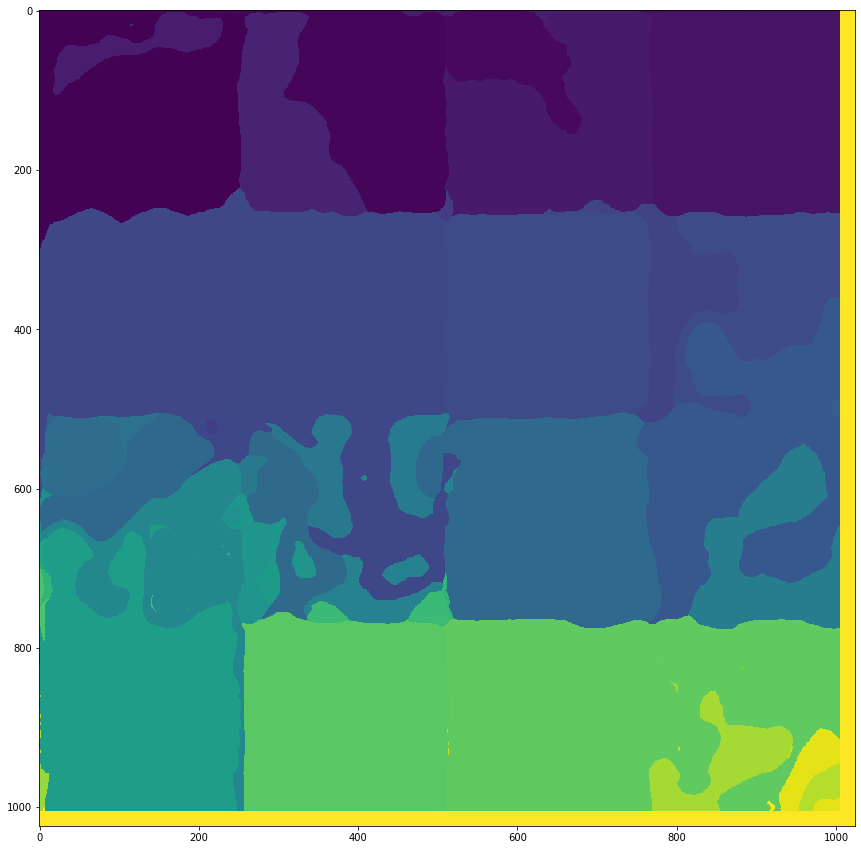

In [386]:
fig = plt.figure(figsize=(15,15))
plt.imshow(out)

NameError: name 'GT' is not defined